# Final Main Implementation

> This is a the main CNN implementation to recognize images of sign language digits.

In [47]:
# libraries:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

### Defining the CNN model

In [48]:
def build_cnn(input_shape=(64, 64, 1), num_classes=10):
    model = models.Sequential([
        # Convolutional Layers
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.1),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.1),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.1),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer='l2'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [49]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

### Loading and preprocessing the data

In [50]:
# Load images and labels
X = np.load('data/X.npy').astype('float32')
y = np.load('data/Y.npy')

In [51]:
# Add channel dimension (grayscale)
X = X.reshape(-1, 64, 64, 1)  # New shape: (2062, 64, 64, 1)

In [52]:
# Spliting the data into train & validation (80%) / testing (%20)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [53]:
# Convert one-hot labels to integers 
y_trainval = np.argmax(y_trainval, axis=1)
y_test = np.argmax(y_test, axis=1)

In [54]:
# Initilizing the k-folds CV (this was for choosing the best model while experimenting)
k = 10  # chosen to be the most optimal
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [55]:
# Data Augmentation: helps increase the diversity of training data by applying random transformations like rotation and zoom
datagen = ImageDataGenerator(
    rotation_range=15,           # Randomly rotate images in the range (degrees)
    zoom_range=0.1,              # Randomly zoom images
    width_shift_range=0.1,       # Randomly shift images horizontally
    height_shift_range=0.1,      # Randomly shift images vertically
    cval=0                       # Fill value for empty areas
)

### Training the model

In [56]:
model = build_cnn()
model.summary()

/Users/anthamorious/Library/Mobile Documents/com~apple~CloudDocs/University/University of Houston/Semesters/🎓 Spring 2025/🌹 COSC 4337 - Data Science II/Project/Final report/COSC4337-project-main/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,194 (1.48 MB)

 Trainable params: 388,746 (1.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [57]:
# Training the model on all of the training and validation set
history = model.fit(X_trainval, y_trainval,
                 epochs=30,
                 batch_size=32,
                 validation_data=(X_test, y_test),
                 callbacks=callbacks) 

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.3367 - loss: 3.5950 - val_accuracy: 0.0993 - val_loss: 6.3700 - learning_rate: 0.0010
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.7920 - loss: 1.7827 - val_accuracy: 0.1186 - val_loss: 7.5445 - learning_rate: 0.0010
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8712 - loss: 1.3052 - val_accuracy: 0.2010 - val_loss: 5.8000 - learning_rate: 0.0010
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8981 - loss: 1.1101 - val_accuracy: 0.2034 - val_loss: 4.4471 - learning_rate: 0.0010
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9260 - loss: 0.8878 - val_accuracy: 0.2349 - val_loss: 3.4559 - learning_rate: 0.0010
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9583 - loss: 0.6900 - val_accuracy: 0.2785 - val_loss: 2.7890 - learning_rate: 0.0010
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9624 - loss: 0.6151 - val_acc

In [60]:
#model.save('sign_language_digits.h5')  # Save the trained model

### Evaluating the model

In [58]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.2%}")

13/13 - 0s - 13ms/step - accuracy: 0.9588 - loss: 0.2076
Test Accuracy: 95.88%


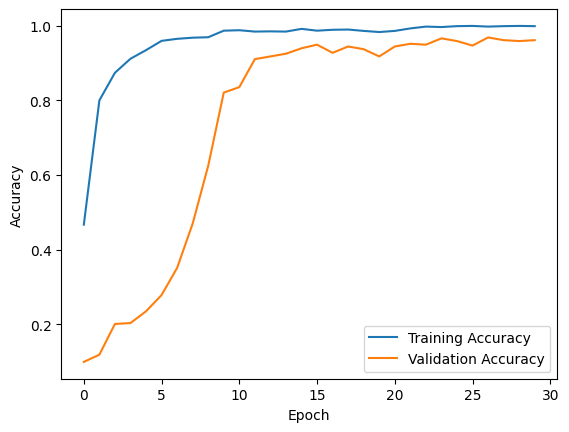

In [65]:
# Plot Training vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

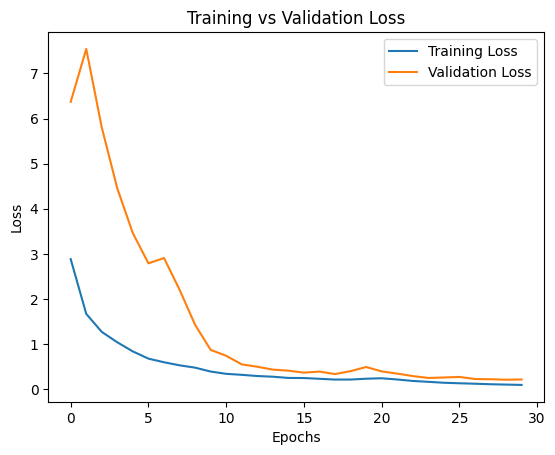

In [66]:
# Plot Training vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.title('Training vs Validation Loss')
plt.show()

In [62]:
# Predict on Test Set
y_pred = model.predict(X_test).argmax(axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [63]:
# Classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        41
           1       0.98      0.98      0.98        41
           2       0.98      0.98      0.98        41
           3       1.00      0.95      0.97        41
           4       0.91      0.95      0.93        42
           5       0.98      0.98      0.98        42
           6       0.97      0.93      0.95        41
           7       0.93      0.95      0.94        41
           8       0.95      0.93      0.94        42
           9       0.95      0.98      0.96        41

    accuracy                           0.96       413
   macro avg       0.96      0.96      0.96       413
weighted avg       0.96      0.96      0.96       413



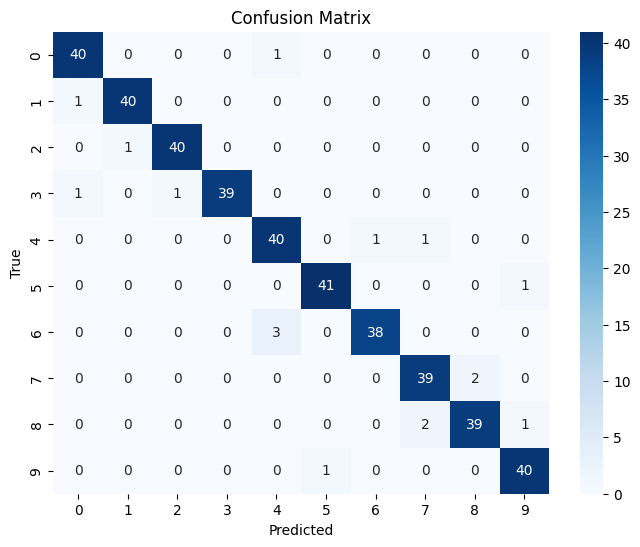

In [64]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()